# Active Learning
If the cell bellow runs without any errors you should have all the necesary stuff, if not the best way to install would be to use the `requirements.txt` file with pip:
```
pip install -r requirements.txt
```
Note: This is a notebook, so please execute the cells in the order they are provided.

In [1]:
import utils

### Data
Let's fetch the [20 News Groups](http://qwone.com/~jason/20Newsgroups/) dataset and do some simple feature extraction using [tfidf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) vectorizer.

In [2]:
from utils import load_news20
from sklearn.feature_extraction.text import TfidfVectorizer

# download the 20 News Group dataset, this may take a minute
train_data, test_data, class_names = load_news20()

# extract train and test datasets
X_raw_train, y_train_full = train_data
X_raw_test, y_test_full = test_data

# maximum vocabulary size 
max_features = 20000

# vectorize the datasets with tfidf
tfidf = TfidfVectorizer(max_features=max_features, stop_words='english')
X_train_full = tfidf.fit_transform(X_raw_train)
X_test_full = tfidf.transform(X_raw_test)

We can check what message boards the samples come from

In [3]:
class_names

['atheism',
 'graphics',
 'ms-windows.misc',
 'pc.hardware',
 'mac.hardware',
 'ms-windows.x',
 'misc.forsale',
 'autos',
 'motorcycles',
 'baseball',
 'hockey',
 'crypt',
 'electronics',
 'med',
 'space',
 'christian',
 'guns',
 'mideast',
 'politics.misc',
 'religion.misc']

For now we will use two classes: atheism and christianity

In [4]:
from utils import extract_subset

# the two classes we'll deal with for now
classes = ['atheism', 'christian']

# extract the subset from the train dataset
X_train, y_train = extract_subset(X=X_train_full, 
                                  y=y_train_full, 
                                  classes=classes, 
                                  names=class_names)

# extract the subset from the test dataset
X_test, y_test = extract_subset(X=X_test_full, 
                                y=y_test_full, 
                                classes=classes, 
                                names=class_names)

Here's the final data

In [5]:
import numpy as np

print("Traning set size: {} samples, {} features".format(*X_train.shape))
print("Testing set size: {} samples, {} features".format(*X_test.shape))

labels, counts = np.unique(y_train, return_counts=True)
print("{} classes:\n{}".format(len(labels), 
                              "\n".join("  {}: {} samples".format(classes[i], 
                                                                    count) for i, count in enumerate(counts))))

Traning set size: 1079 samples, 20000 features
Testing set size: 717 samples, 20000 features
2 classes:
  atheism: 480 samples
  christian: 599 samples


### Model
Let's check how a very simple classifier performs on this task

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# initialize and train a naive bayes model
model = MultinomialNB(alpha=1e-6)
model.fit(X=X_train, y=y_train)

# evaluate its performance on the test set
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9442119944211994

Not bad, let's try to get similar score with as little labelled samples as possible. Enter: Active Learning.

### Active Learning loop

In [7]:
import sklearn
from typing import Callable, Union, List
from modAL.models import ActiveLearner, Committee
from utils import delete_rows_csr, committee_decision


def active_learning(model: Union[sklearn.base.BaseEstimator, List[sklearn.base.BaseEstimator]],
                    query_strategy: Callable,
                    X: np.ndarray,
                    y: Union[np.ndarray, list],
                    X_test: np.ndarray,
                    y_test: Union[np.ndarray, list],
                    budget: int = 50,
                    warm_start: float = 0.01) -> list:
    """
    Active Learning loop that runs an experiment querying `budget` points and returns a list of scores
    at each iteration
    :param model: sklearn.base.BaseEstimator, list
        Classifier to train in the Active Learning process or list of classifiers when traning a committee
    :param query_strategy: callable, None
        Query function that accepts a model and a pool and returns indices and queries samples,
        see https://modal-python.readthedocs.io/en/latest/content/overview/Extending-modAL.html for details.
    :param X: np.ndarray
        Pool of training samples
    :param y: np.ndarray, list
        Labels for the traning pool
    :param X_test: np.ndarray
        Test set to score model on
    :param y_test: np.ndarray, list
        Labels for the test set
    :param budget: int
        How many samples to label
    :param warm_start: float
        Fraction of the traning set X to use as the starting point.
        
    :return: list
        Model score at each time step, model.score(X_test, y_test)
    """

    # sample the initial training set
    init_ids = np.random.choice(y.shape[0], size=int(warm_start * y.shape[0]), replace=False)
    X_init, y_init = X[init_ids], y[init_ids]
    
    # delete the initial traning set from the pool
    X = delete_rows_csr(X, obj=init_ids)
    y = np.delete(y, obj=init_ids)
    
    # initialize the learner
    if isinstance(model, sklearn.base.BaseEstimator):  # single classifier
        learner = ActiveLearner(estimator=model,
                                X_training=X_init,
                                y_training=y_init,
                                query_strategy=query_strategy)
    elif isinstance(model, list):  # committee
        learner_list = [ActiveLearner(estimator=m,
                                      X_training=X_init,
                                      y_training=y_init) for m in model]
        # create the committee
        learner = Committee(learner_list=learner_list,
                            query_strategy=query_strategy)
        # use bagging to train the committe on bootstraped training sets
        learner.rebag()
    else:
        raise TypeError("Unsupported model type: {}".format(type(model)))
    
    # prepare an empty list for the model scores
    scores = []
    
    # main AL loop
    for i in range(budget):
        # query the learner for a new sample
        query_ids, _ = learner.query(X)
        # "ask" the oracle for labels
        X_query, y_query = X[query_ids], y[query_ids]
        # train the learner using the newly acquired labels
        learner.teach(X=X_query, y=y_query)
        
        # delete the new samples from the pool
        X = delete_rows_csr(X, obj=query_ids)
        y = np.delete(y, obj=query_ids)
        
        # evaluate the model and save its performance
        if isinstance(learner, ActiveLearner):
            y_pred = learner.predict(X=X_test)
        elif isinstance(learner, Committee):
            y_pred = committee_decision(learner.vote(X=X_test))
        
        acc = accuracy_score(y_test, y_pred)
        scores.append(acc)

    return scores

### Experiments
Let's test our model in the active learning framework.

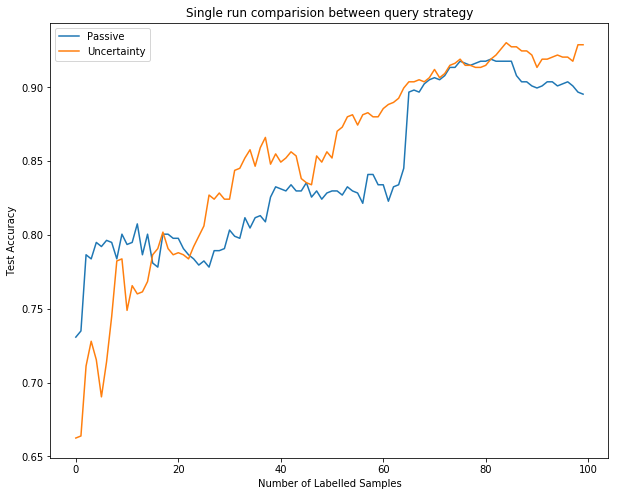

In [8]:
%matplotlib inline
from utils import passive_sampling, plot
from modAL.uncertainty import uncertainty_sampling
from functools import partial


np.random.seed(1337)
budget = 100  # the number of istances that will be queried for labels

# lets simplfy the active_learning function for the ease of use
al = partial(active_learning,
             model=MultinomialNB(alpha=1e-6),
             X=X_train, 
             y=y_train,
             budget=budget,
             X_test=X_test,
             y_test=y_test)

passive_score = al(query_strategy=passive_sampling)
unc_score = al(query_strategy=uncertainty_sampling)

plot([passive_score, unc_score], names=['Passive', 'Uncertainty'])

* We are able to get to the performance of a model trained on the whole dataset in just 100 samples! 
* Query strategy based on uncertainty sampling seems to perform a bit better than the random one, but...

### Exercise
Try changing the random seed (or remove it completely) and run the cell few times to see hot the two strategies compare.

### Result
Active learning process is very depednant on the initial traning set, to counteract this we should run the whole process multiple times, resampling the initial set each time if we want to get statistically sensible comparison of the query strategies.

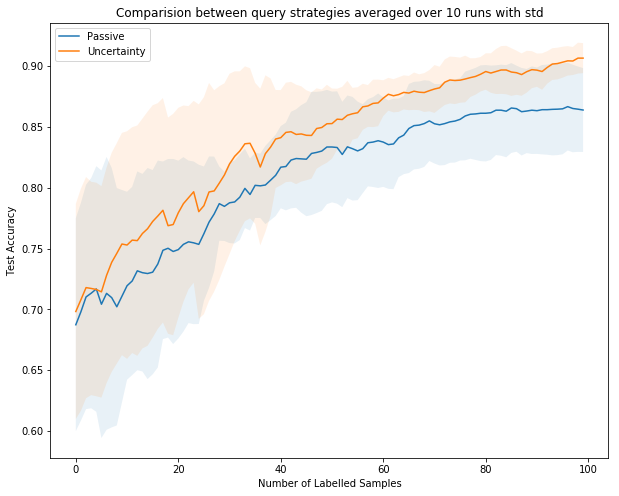

In [9]:
from tqdm import tqdm_notebook as tqdm

np.random.seed(1337)

# prepare lists for collecting the results
passive_scores = []
unc_scores = []

# run the whole AL experiment 10 times
for _ in tqdm(range(10)):  # you can lower this number to decrease run time
    # run the passive strategy
    passive_score = al(query_strategy=passive_sampling)
    passive_scores.append(passive_score)
    # run the uncertainty sampling strategy
    unc_score = al(query_strategy=uncertainty_sampling)
    unc_scores.append(unc_score)

# plot the results
plot([passive_scores, unc_scores], names=['Passive', 'Uncertainty'])

Now we can be less uncertain that the Uncertainty Sampling performs better than the random sampling.

### More query strategies

Ok, so we've tested a query strategy based on class probabilites, but what if our model is not equiped with such a thing, or the probabilities estimation is very computationally expensive?

Fortunately there are other types of query strategies, here we'll test a Query by Committee strategy using Vote Entropy as out sampling strategy.

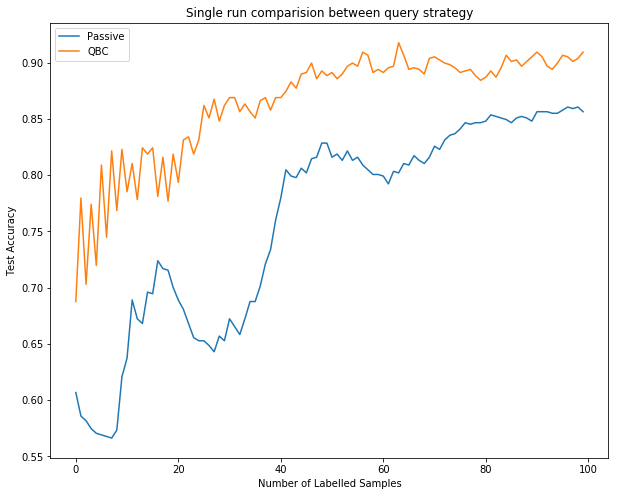

In [10]:
from sklearn.svm import LinearSVC
from modAL.disagreement import vote_entropy_sampling


np.random.seed(42)

# a list of models, this is out Committee (or ensamble)
models = [LinearSVC(C=1), LinearSVC(C=0.1), LinearSVC(C=10)]

learner_list = [ActiveLearner(estimator=m,
                              X_training=X_train,
                              y_training=y_train) for m in models]
# create the committee
learner = Committee(learner_list=learner_list,
                    query_strategy=vote_entropy_sampling)

# run the QBC and passive strategies
qbc_score = al(model=models, query_strategy=vote_entropy_sampling)
passive_score = al(model=models, query_strategy=passive_sampling)
# plot the results
plot([passive_score, qbc_score], names=['Passive', 'QBC'])

### Playground
Play around with the dataset an the AL framework, few things to try:

* increase the number of classes in the dataset to make the problem harder,
* on a multiclass (>2) problem, compare the 3 uncertainty query strategies from [modAL.uncertainty](https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html): [entropy_sampling](https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html#modAL.uncertainty.entropy_sampling), [margin_sampling](https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html#modAL.uncertainty.margin_sampling) and the already used [uncertainty_sampling](https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html#modAL.uncertainty.uncertainty_sampling), **Extra Credits**: why not do this on the 2 class problem?
* check how QBC compares to previously tested strategies on the same model, say MultinomialNB averaging multi runs to combat the randomness.